In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
from itertools import combinations

In [2]:
# Loading the dataset
data = pd.read_csv("C:/Users/Dell/Desktop/Applied ML/Project/project_eda.csv")
data.info

<bound method DataFrame.info of                                                Indicator              Group  \
0      Took Prescription Medication for Mental Health...  National Estimate   
1      Took Prescription Medication for Mental Health...             By Age   
2      Took Prescription Medication for Mental Health...             By Age   
3      Took Prescription Medication for Mental Health...             By Age   
4      Took Prescription Medication for Mental Health...             By Age   
...                                                  ...                ...   
10399  Needed Counseling or Therapy But Did Not Get I...           By State   
10400  Needed Counseling or Therapy But Did Not Get I...           By State   
10401  Needed Counseling or Therapy But Did Not Get I...           By State   
10402  Needed Counseling or Therapy But Did Not Get I...           By State   
10403  Needed Counseling or Therapy But Did Not Get I...           By State   

               Stat

In [3]:
# Identify categorical columns
cat_cols = data.select_dtypes(include=['object', 'category']).columns
print(cat_cols)

# Applying Chi-squared test on each pair of categorical columns
results = []

for col1, col2 in combinations(cat_cols, 2):
    # Create contingency table
    contingency_table = pd.crosstab(data[col1], data[col2])

    # Apply Chi-squared test
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    
    # Store the result
    results.append({
        'Variable 1': col1,
        'Variable 2': col2,
        'Chi-squared Statistic': chi2,
        'p-value': p,
        'Degrees of Freedom': dof
    })

# Converting results to a DataFrame
chi_squared_results = pd.DataFrame(results)

# Filter for significant results 
alpha = 0.05
significant_results = chi_squared_results[chi_squared_results['p-value'] < alpha]

# Printing significant associations
print("Significant Chi-squared test results (p < 0.05):")
print(significant_results)

Index(['Indicator', 'Group', 'State', 'Subgroup', 'Phase', 'Time Period Label',
       'Quartile Range', 'Usage_Category'],
      dtype='object')
Significant Chi-squared test results (p < 0.05):
           Variable 1         Variable 2  Chi-squared Statistic  \
5           Indicator     Quartile Range           19605.005600   
6           Indicator     Usage_Category            6850.566857   
7               Group              State           10404.000000   
8               Group           Subgroup           93636.000000   
9               Group              Phase            1482.801262   
10              Group  Time Period Label            1668.711109   
11              Group     Quartile Range           10230.735893   
12              Group     Usage_Category             539.339645   
13              State           Subgroup          530604.000000   
14              State              Phase             944.362531   
16              State     Quartile Range           40068.922517   
1

In [4]:
# On the basis of the above found association between the columns

# Dropping the columns "Time Period Start Date" and "Time Period End Date" as 
#data_reduced = data.drop(columns=["Time Period Start Date", "Time Period End Date"])
#print(data_reduced.columns)

In [5]:
import category_encoders as ce

y_original = data['Subgroup']
data = data.drop(columns=["Subgroup"])
cat_cols_mod = data.select_dtypes(include=['object', 'category']).columns
print(cat_cols_mod)

# Applying Binary Encoding because of high-cardinalty of the few columns
encoder = ce.BinaryEncoder(cols=cat_cols_mod)
data_encoded = encoder.fit_transform(data)

# Verify the result
print(data_encoded.columns)

Index(['Indicator', 'Group', 'State', 'Phase', 'Time Period Label',
       'Quartile Range', 'Usage_Category'],
      dtype='object')
Index(['Indicator_0', 'Indicator_1', 'Indicator_2', 'Group_0', 'Group_1',
       'Group_2', 'Group_3', 'State_0', 'State_1', 'State_2', 'State_3',
       'State_4', 'State_5', 'Phase_0', 'Phase_1', 'Phase_2', 'Phase_3',
       'Time Period', 'Time Period Label_0', 'Time Period Label_1',
       'Time Period Label_2', 'Time Period Label_3', 'Time Period Label_4',
       'Time Period Label_5', 'Value', 'LowCI', 'HighCI', 'Quartile Range_0',
       'Quartile Range_1', 'Quartile Range_2', 'Quartile Range_3',
       'Quartile Range_4', 'Quartile Range_5', 'Quartile Range_6',
       'Quartile Range_7', 'Quartile Range_8', 'Usage_Category_0',
       'Usage_Category_1'],
      dtype='object')


In [27]:
# Feature selection before applying the model
from sklearn.feature_selection import SelectKBest, chi2

# Since predicting the demographic subgroup (e.g., age range or gender) based 
# on the associated health statistics and time-period
#  Features ie., all the columns other than Subgroup column
X = data_encoded 
# Target variable
y = y_original

# Applying Chi-squared feature selection
selector = SelectKBest(chi2, k='all')  
X_selected = selector.fit_transform(X, y)

# Get the selected feature names
selected_features = X.columns[selector.get_support()]
print("Selected features:", selected_features)

Selected features: Index(['Indicator_0', 'Indicator_1', 'Indicator_2', 'Group_0', 'Group_1',
       'Group_2', 'Group_3', 'State_0', 'State_1', 'State_2', 'State_3',
       'State_4', 'State_5', 'Phase_0', 'Phase_1', 'Phase_2', 'Phase_3',
       'Time Period', 'Time Period Label_0', 'Time Period Label_1',
       'Time Period Label_2', 'Time Period Label_3', 'Time Period Label_4',
       'Time Period Label_5', 'Value', 'LowCI', 'HighCI', 'Quartile Range_0',
       'Quartile Range_1', 'Quartile Range_2', 'Quartile Range_3',
       'Quartile Range_4', 'Quartile Range_5', 'Quartile Range_6',
       'Quartile Range_7', 'Quartile Range_8', 'Usage_Category_0',
       'Usage_Category_1'],
      dtype='object')


In [28]:
# Splitting the dataset into train(70%) and test(30%) data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Encode the target variable
le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42, stratify=y)

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and test data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [32]:
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

# Ensemble method (Random Forest)
rf_classifier = RandomForestClassifier(class_weight=class_weight_dict, n_estimators=200, random_state=42)
rf_classifier.fit(X_train_scaled, y_train)

RandomForestClassifier(class_weight={0: 0.8587264150943397,
                                     1: 0.8587264150943397,
                                     2: 0.8587264150943397,
                                     3: 0.8587264150943397,
                                     4: 0.8587264150943397,
                                     5: 0.8587264150943397,
                                     6: 0.8587264150943397,
                                     7: 0.978763440860215,
                                     8: 0.9894021739130435,
                                     9: 0.9894021739130435,
                                     10: 0.978763440860215,
                                     11: 0.8587264150943397,
                                     12: 2.4601351351351353,
                                     13: 0.978763440860215,
                                     14: 2.4601351351351...
                                     15: 2.4601351351351353,
                                     16: 0.978763440860215,
                                     17: 0.978763440860215,
                                     18: 0.978763440860215,
                                     19: 0.8587264150943397,
                                     20: 0.978763440860215,
                                     21: 0.8587264150943397,
                                     22: 0.8587264150943397,
                                     23: 0.9894021739130435,
                                     24: 2.4601351351351353,
                                     25: 0.9894021739130435,
                                     26: 0.9894021739130435,
                                     27: 0.8587264150943397,
                                     28: 0.8587264150943397,
                                     29: 0.978763440860215, ...},
                       n_estimators=200, random_state=42)

In [25]:
#from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest Classifier
#rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model on the training data
#rf_classifier.fit(X_train_scaled, y_train)

In [33]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Make predictions on the test data
y_pred = rf_classifier.predict(X_test_scaled)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

# Classification report (precision, recall, F1-score, etc.)
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 87.89%
Classification Report:
               precision    recall  f1-score   support

           0       0.39      0.30      0.34        46
           1       0.30      0.35      0.32        46
           2       0.45      0.37      0.40        46
           3       0.44      0.48      0.46        46
           4       0.57      0.54      0.56        46
           5       0.74      0.76      0.75        46
           6       0.66      0.76      0.71        46
           7       1.00      1.00      1.00        39
           8       1.00      1.00      1.00        40
           9       1.00      1.00      1.00        40
          10       1.00      1.00      1.00        39
          11       0.58      0.54      0.56        46
          12       0.80      0.53      0.64        15
          13       1.00      1.00      1.00        39
          14       0.78      0.93      0.85        15
          15       0.93      0.93      0.93        15
          16       1.00      1.00      1

In [19]:
# Get feature importances
importances = rf_classifier.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,  # or the original feature names if you have them
    'Importance': importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the feature importances
print(feature_importance_df)

                Feature  Importance
25                LowCI    0.101199
26               HighCI    0.096784
24                Value    0.089617
11              State_4    0.070184
9               State_2    0.068232
8               State_1    0.063537
12              State_5    0.063494
10              State_3    0.063366
7               State_0    0.062554
17          Time Period    0.031710
6               Group_3    0.030722
5               Group_2    0.027261
4               Group_1    0.023336
3               Group_0    0.017811
2           Indicator_2    0.017558
1           Indicator_1    0.015438
36     Usage_Category_0    0.012884
23  Time Period Label_5    0.010159
37     Usage_Category_1    0.010147
0           Indicator_0    0.009921
22  Time Period Label_4    0.009580
21  Time Period Label_3    0.008264
34     Quartile Range_7    0.007406
19  Time Period Label_1    0.007125
16              Phase_3    0.006994
35     Quartile Range_8    0.006923
15              Phase_2    0

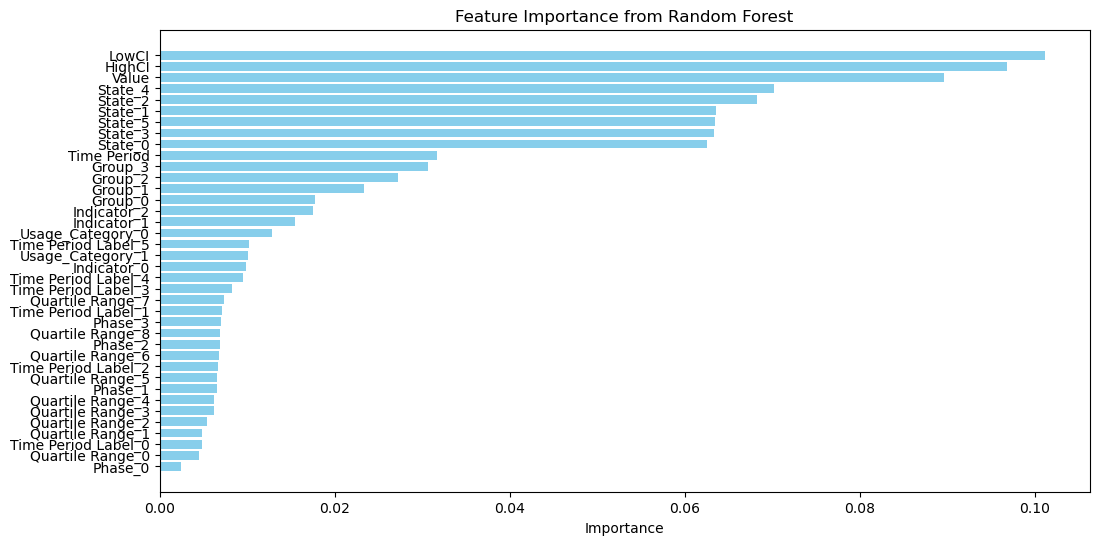

In [31]:
import matplotlib.pyplot as plt
# Visualize the feature importances
plt.figure(figsize=(12, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance from Random Forest')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()